# Polymer Representation Analysis Resources

https://zoehlerbz.medium.com/molecule-clustering-using-the-butina-algorithm-application-with-python-and-rdkit-ffb5b5721447

https://github.com/zoehlerbz/rdkit_basico

https://www.osti.gov/pages/servlets/purl/2328569

https://github.com/PatWalters/practical_cheminformatics_tutorials?tab=readme-ov-file

https://drzinph.com/maccs-fingerprints-in-python-part-2/

https://www.rdkit.org/docs/source/rdkit.ML.Cluster.Murtagh.html

https://github.com/argonne-lcf/molan/tree/master/code/melting_predict_Spark_RF



In [4]:
# Install required packages
%pip install rdkit umap-learn tqdm scikit-learn pandas numpy matplotlib plotly transformers accelerate torch

In [5]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, MACCSkeys, Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score, adjusted_rand_score, normalized_mutual_info_score,
    accuracy_score, f1_score, classification_report
)
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

import umap
import matplotlib.pyplot as plt
import plotly.express as px

import torch
from transformers import AutoTokenizer, AutoModel

print("All imports successful!")

All imports successful!


## 1. Load and Clean Dataset
### 1.1 Load Data

In [6]:
import pandas as pd
RAW_URL = "https://raw.githubusercontent.com/Syedomershah99/AI-for-Polymer-Representation/main/PI1070.csv"
df_raw = pd.read_csv(RAW_URL, engine="c", low_memory=False)
print(df_raw.shape)
df_raw = pd.read_csv(RAW_URL)
print(f"Loaded dataset: {df_raw.shape}")
print(f"Columns: {df_raw.columns[:15].tolist()}...")
df_raw.head(3)

(1077, 157)
Loaded dataset: (1077, 157)
Columns: ['monomer_ID', 'smiles', 'mol_weight_monomer', 'atomic_weight_mean', 'vdw_volume_monomer', 'qm_total_energy_monomer', 'qm_homo_monomer', 'qm_lumo_monomer', 'qm_dipole_monomer', 'qm_dipole_x_monomer', 'qm_dipole_y_monomer', 'qm_dipole_z_monomer', 'qm_polarizability_monomer', 'qm_polarizability_xx_monomer', 'qm_polarizability_yy_monomer']...


,monomer_ID,smiles,mol_weight_monomer,atomic_weight_mean,vdw_volume_monomer,qm_total_energy_monomer,qm_homo_monomer,qm_lumo_monomer,qm_dipole_monomer,qm_dipole_x_monomer,...,TC_improper_min,TC_improper_max,TC_improper_std,TC_improper_count,TC_kspace,TC_kspace_min,TC_kspace_max,TC_kspace_std,TC_kspace_count,polymer_class
0,PI1,*CC*,28.054,4.675667,45.008,-209676.7175,-12.037272,3.128817,0.000009,0.000006,...,0.0,0.0,0.0,5.0,0.000014,-0.000028,0.000029,0.000024,5.0,1
1,PI2,*C(C*)C,42.081,4.675667,61.624,-312948.9242,-11.576865,3.039961,0.077278,0.003980,...,0.0,0.0,0.0,5.0,0.000279,-0.000165,0.000562,0.000302,5.0,1
2,PI3,*C(C*)CC,56.108,4.675667,78.424,-416219.2389,-11.423908,2.987135,0.081852,-0.003192,...,0.0,0.0,0.0,5.0,0.000059,-0.000043,0.000288,0.000133,5.0,1


### 1.2 Canonicalize SMILES and Clean Dataset

In [7]:
def canonicalize_smiles(smiles):
    """
    Canonicalize SMILES string using RDKit.
    Returns canonical SMILES or None if invalid.
    """
    try:
        smiles = str(smiles).strip()
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return Chem.MolToSmiles(mol, canonical=True)
    except Exception:
        return None

def clean_dataset(df):
    """
    Clean the dataset:
    1. Canonicalize SMILES
    2. Remove invalid entries
    3. Deduplicate based on canonical SMILES
    """
    df = df.copy()
    
    # Step 1: Canonicalize SMILES
    print("Canonicalizing SMILES...")
    tqdm.pandas(desc="Canonicalizing")
    df['smiles_canonical'] = df['smiles'].progress_apply(canonicalize_smiles)
    
    # Step 2: Remove invalid SMILES
    n_before = len(df)
    df = df[df['smiles_canonical'].notna()].reset_index(drop=True)
    n_invalid = n_before - len(df)
    print(f"Removed {n_invalid} invalid SMILES entries")
    
    # Step 3: Deduplicate based on canonical SMILES
    n_before = len(df)
    df = df.drop_duplicates(subset='smiles_canonical', keep='first').reset_index(drop=True)
    n_duplicates = n_before - len(df)
    print(f"Removed {n_duplicates} duplicate SMILES entries")
    
    # Create mol objects
    df['mol'] = df['smiles_canonical'].apply(lambda s: Chem.MolFromSmiles(s))
    
    print(f"Final dataset size: {len(df)}")
    return df

df = clean_dataset(df_raw)
print(f"\nDataset summary:")
print(f"  - Total polymers: {len(df)}")
print(f"  - Has polymer_class: {'polymer_class' in df.columns}")
if 'polymer_class' in df.columns:
    print(f"  - Unique classes: {df['polymer_class'].nunique()}")
    print(f"  - Class distribution:\n{df['polymer_class'].value_counts()}")

Canonicalizing SMILES...


Canonicalizing:   0%|          | 0/1077 [00:00<?, ?it/s]

Removed 0 invalid SMILES entries
Removed 0 duplicate SMILES entries
Final dataset size: 1077

Dataset summary:
  - Total polymers: 1077
  - Has polymer_class: True
  - Unique classes: 20
  - Class distribution:
polymer_class
13    261
3     162
2     161
4     118
1      83
7      67
9      67
10     50
15     40
16     11
11     11
8      11
6       9
5       8
21      6
12      5
20      4
14      1
19      1
18      1
Name: count, dtype: int64


## 2. Compute Polymer Representations

We compute four types of representations:
1. **Morgan Fingerprints** (ECFP) - circular fingerprints capturing local atom environments
2. **MACCS Keys** - 166 predefined structural keys (standard substructure patterns)
3. **RDKit Descriptors + MACCS Motifs** - physicochemical descriptors with substructure information
4. **Transformer Embeddings** - pretrained polyBERT embeddings

### 2.1 Morgan Fingerprints (ECFP)

In [8]:
def compute_morgan_fingerprints(mols, radius=2, n_bits=2048):
    """
    Compute Morgan fingerprints (ECFP) for a list of molecules.
    Returns both RDKit bitvectors and numpy arrays.
    """
    fps_rdkit = []  # For Tanimoto calculations
    fps_array = []  # For ML models
    
    for mol in tqdm(mols, desc="Computing Morgan FPs"):
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        fps_rdkit.append(fp)
        
        arr = np.zeros((n_bits,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        fps_array.append(arr)
    
    return fps_rdkit, np.vstack(fps_array)

fps_morgan_rdkit, X_morgan = compute_morgan_fingerprints(df['mol'].tolist())
print(f"Morgan fingerprints shape: {X_morgan.shape}")
print(f"Sparsity: {100 * (X_morgan == 0).sum() / X_morgan.size:.1f}%")

Computing Morgan FPs:   0%|          | 0/1077 [00:00<?, ?it/s]

Morgan fingerprints shape: (1077, 2048)
Sparsity: 98.5%


### 2.2 MACCS Keys (166 Standard Substructure Patterns)

In [9]:
def compute_maccs_keys(mols):
    """
    Compute MACCS keys (166-bit structural keys) for molecules.
    MACCS keys are standard substructure patterns widely used in cheminformatics.
    """
    fps_rdkit = []
    fps_array = []
    
    for mol in tqdm(mols, desc="Computing MACCS keys"):
        fp = MACCSkeys.GenMACCSKeys(mol)
        fps_rdkit.append(fp)
        
        arr = np.zeros((167,), dtype=np.int8)  # MACCS has 167 bits (0-166)
        DataStructs.ConvertToNumpyArray(fp, arr)
        fps_array.append(arr)
    
    return fps_rdkit, np.vstack(fps_array)

fps_maccs_rdkit, X_maccs = compute_maccs_keys(df['mol'].tolist())
print(f"MACCS keys shape: {X_maccs.shape}")
print(f"Active bits per molecule (mean): {X_maccs.sum(axis=1).mean():.1f}")

Computing MACCS keys:   0%|          | 0/1077 [00:00<?, ?it/s]

MACCS keys shape: (1077, 167)
Active bits per molecule (mean): 27.2


### 2.3 RDKit Descriptors + MACCS Motifs

In [10]:
def compute_rdkit_descriptors(mols):
    """
    Compute all RDKit molecular descriptors.
    Handles NaN/Inf values by imputing with column medians.
    """
    descriptor_names = [d[0] for d in Descriptors._descList]
    descriptor_fns = [d[1] for d in Descriptors._descList]
    
    results = []
    for mol in tqdm(mols, desc="Computing RDKit descriptors"):
        vals = []
        for fn in descriptor_fns:
            try:
                v = fn(mol)
                if v is None or (isinstance(v, float) and (np.isnan(v) or np.isinf(v))):
                    v = np.nan
            except Exception:
                v = np.nan
            vals.append(v)
        results.append(vals)
    
    X = np.array(results, dtype=np.float32)
    
    # Remove columns that are all NaN
    valid_mask = ~np.all(np.isnan(X), axis=0)
    X = X[:, valid_mask]
    kept_names = [n for n, keep in zip(descriptor_names, valid_mask) if keep]
    
    # Impute remaining NaNs with column medians
    col_median = np.nanmedian(X, axis=0)
    nan_idx = np.where(np.isnan(X))
    X[nan_idx] = np.take(col_median, nan_idx[1])
    
    return X, kept_names

X_rdkit_desc, rdkit_desc_names = compute_rdkit_descriptors(df['mol'].tolist())
print(f"RDKit descriptors shape: {X_rdkit_desc.shape}")

# Combine RDKit descriptors with MACCS keys as motif representation
X_desc_maccs = np.hstack([X_rdkit_desc, X_maccs.astype(np.float32)])
print(f"RDKit + MACCS combined shape: {X_desc_maccs.shape}")

Computing RDKit descriptors:   0%|          | 0/1077 [00:00<?, ?it/s]

RDKit descriptors shape: (1077, 209)
RDKit + MACCS combined shape: (1077, 376)


### 2.4 Transformer Embeddings (polyBERT)

In [11]:
def compute_transformer_embeddings(smiles_list, model_name="kuelumbus/polyBERT", 
                                    batch_size=64, max_len=256, pooling="cls"):
    """
    Compute transformer embeddings using a pretrained SMILES encoder.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval()
    
    embeddings = []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(smiles_list), batch_size), desc="Computing embeddings"):
            batch = smiles_list[i:i+batch_size]
            
            tokens = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=max_len,
                return_tensors="pt"
            ).to(device)
            
            output = model(**tokens)
            hidden = output.last_hidden_state
            
            if pooling == "cls":
                emb = hidden[:, 0, :]
            else:  # mean pooling
                mask = tokens["attention_mask"].unsqueeze(-1)
                emb = (hidden * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)
            
            embeddings.append(emb.cpu().numpy())
    
    return np.vstack(embeddings)

X_transformer = compute_transformer_embeddings(df['smiles_canonical'].tolist())
print(f"Transformer embeddings shape: {X_transformer.shape}")

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/84.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/756 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/101M [00:00<?, ?B/s]

Computing embeddings:   0%|          | 0/17 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/101M [00:00<?, ?B/s]

Transformer embeddings shape: (1077, 600)


### 2.5 Standardize Representations

In [12]:
# Standardize continuous representations (not binary fingerprints)
scaler_rdkit = StandardScaler()
X_rdkit_desc_scaled = scaler_rdkit.fit_transform(X_rdkit_desc)

scaler_desc_maccs = StandardScaler()
X_desc_maccs_scaled = scaler_desc_maccs.fit_transform(X_desc_maccs)

scaler_transformer = StandardScaler()
X_transformer_scaled = scaler_transformer.fit_transform(X_transformer)

# Summary of all representations
print("\n=== Representation Summary ===")
print(f"Morgan FP (binary):        {X_morgan.shape}")
print(f"MACCS Keys (binary):       {X_maccs.shape}")
print(f"RDKit Desc (scaled):       {X_rdkit_desc_scaled.shape}")
print(f"RDKit+MACCS (scaled):      {X_desc_maccs_scaled.shape}")
print(f"Transformer (scaled):      {X_transformer_scaled.shape}")


=== Representation Summary ===
Morgan FP (binary):        (1077, 2048)
MACCS Keys (binary):       (1077, 167)
RDKit Desc (scaled):       (1077, 209)
RDKit+MACCS (scaled):      (1077, 376)
Transformer (scaled):      (1077, 600)


## 3. Unsupervised Clustering

### 3.1 K-Means Clustering on Transformer Embeddings

K-means analysis:   0%|          | 0/14 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'plots/01_kmeans_analysis.png'

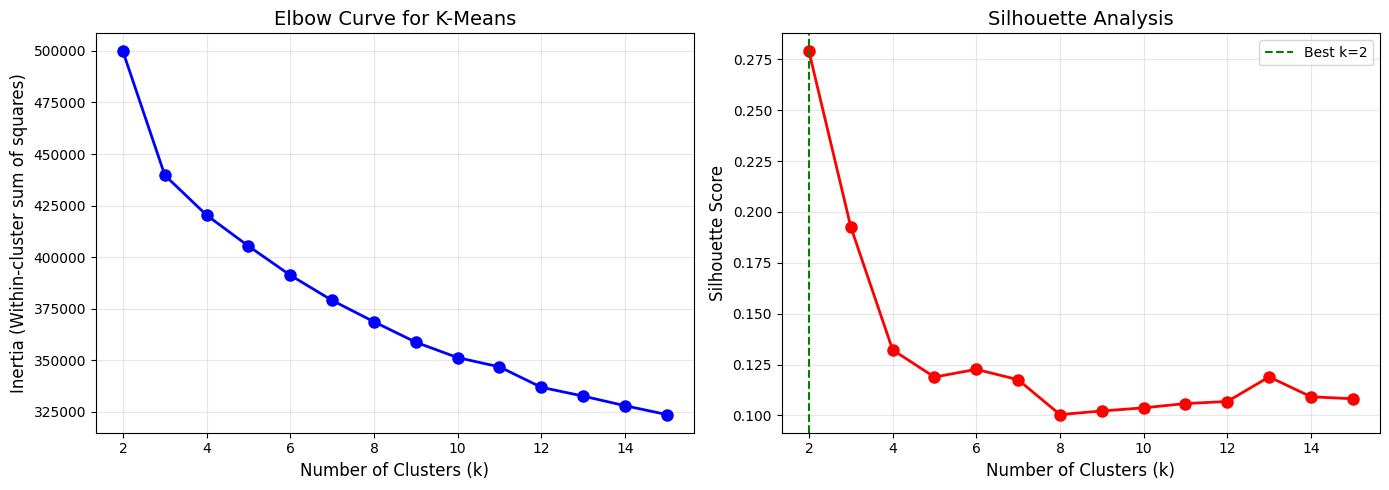

In [13]:
def kmeans_analysis(X, k_range=range(2, 16), random_state=42):
    """
    Perform K-means clustering with elbow curve and silhouette analysis.
    """
    inertias = []
    silhouettes = []
    
    for k in tqdm(k_range, desc="K-means analysis"):
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = kmeans.fit_predict(X)
        
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X, labels))
    
    return list(k_range), inertias, silhouettes

k_values, inertias, silhouettes = kmeans_analysis(X_transformer_scaled)

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow curve
axes[0].plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[0].set_title('Elbow Curve for K-Means', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Silhouette scores
axes[1].plot(k_values, silhouettes, 'ro-', linewidth=2, markersize=8)
best_k = k_values[np.argmax(silhouettes)]
axes[1].axvline(x=best_k, color='g', linestyle='--', label=f'Best k={best_k}')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/01_kmeans_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBest k by silhouette score: {best_k} (score: {max(silhouettes):.4f})")

In [ ]:
# Fit final K-means with optimal k (or use number of known classes if available)
if 'polymer_class' in df.columns:
    n_classes = df['polymer_class'].nunique()
    k_final = n_classes  # Use number of true classes for comparison
else:
    k_final = best_k

print(f"Using k={k_final} for final K-means clustering")

kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
df['kmeans_cluster'] = kmeans_final.fit_predict(X_transformer_scaled)

print(f"K-means cluster distribution:")
print(df['kmeans_cluster'].value_counts().sort_index())

### 3.2 Tanimoto-Distance Clustering (Morgan & MACCS)

#### 3.2.1 Fine-Grained Butina Clustering

In [ ]:
def butina_cluster(fps, cutoff=0.3):
    """
    Butina clustering using Tanimoto distance.
    cutoff: distance threshold (1 - similarity)
    """
    n = len(fps)
    dists = []
    
    for i in tqdm(range(1, n), desc="Computing Tanimoto distances"):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
        dists.extend([1.0 - s for s in sims])
    
    clusters = Butina.ClusterData(dists, nPts=n, distThresh=cutoff, isDistData=True)
    
    # Convert to cluster labels
    labels = np.full(n, -1, dtype=int)
    for cid, members in enumerate(clusters):
        for idx in members:
            labels[idx] = cid
    
    return labels, clusters, dists

# Analyze different cutoff values for Butina clustering
print("=== Analyzing Butina Clustering Cutoffs ===")

def butina_cutoff_analysis(fps, X, cutoffs=np.arange(0.1, 0.6, 0.05)):
    """
    Analyze Butina clustering with different Tanimoto distance cutoffs.
    """
    # First compute distances once
    n = len(fps)
    dists = []
    for i in tqdm(range(1, n), desc="Computing distances"):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
        dists.extend([1.0 - s for s in sims])
    
    results = []
    for cutoff in tqdm(cutoffs, desc="Testing cutoffs"):
        clusters = Butina.ClusterData(dists, nPts=n, distThresh=cutoff, isDistData=True)
        
        labels = np.full(n, -1, dtype=int)
        for cid, members in enumerate(clusters):
            for idx in members:
                labels[idx] = cid
        
        n_clusters = len(clusters)
        n_singletons = sum(1 for c in clusters if len(c) == 1)
        
        # Silhouette (only if > 1 cluster and not all singletons)
        if n_clusters > 1 and n_clusters < n:
            sil = silhouette_score(X, labels)
        else:
            sil = 0
        
        results.append({
            'cutoff': cutoff,
            'n_clusters': n_clusters,
            'n_singletons': n_singletons,
            'silhouette': sil
        })
    
    return pd.DataFrame(results), dists

# Analyze Morgan FP cutoffs
cutoff_results_morgan, dists_morgan = butina_cutoff_analysis(
    fps_morgan_rdkit, X_morgan.astype(np.float32)
)

# Plot cutoff analysis
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Number of clusters vs cutoff
axes[0].plot(cutoff_results_morgan['cutoff'], cutoff_results_morgan['n_clusters'], 'bo-', linewidth=2)
axes[0].set_xlabel('Tanimoto Distance Cutoff', fontsize=12)
axes[0].set_ylabel('Number of Clusters', fontsize=12)
axes[0].set_title('Butina: Clusters vs Cutoff (Morgan FP)', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Singletons vs cutoff
axes[1].plot(cutoff_results_morgan['cutoff'], cutoff_results_morgan['n_singletons'], 'go-', linewidth=2)
axes[1].set_xlabel('Tanimoto Distance Cutoff', fontsize=12)
axes[1].set_ylabel('Number of Singletons', fontsize=12)
axes[1].set_title('Butina: Singletons vs Cutoff', fontsize=14)
axes[1].grid(True, alpha=0.3)

# Silhouette vs cutoff
axes[2].plot(cutoff_results_morgan['cutoff'], cutoff_results_morgan['silhouette'], 'ro-', linewidth=2)
best_cutoff = cutoff_results_morgan.loc[cutoff_results_morgan['silhouette'].idxmax(), 'cutoff']
axes[2].axvline(x=best_cutoff, color='purple', linestyle='--', label=f'Best cutoff={best_cutoff:.2f}')
axes[2].set_xlabel('Tanimoto Distance Cutoff', fontsize=12)
axes[2].set_ylabel('Silhouette Score', fontsize=12)
axes[2].set_title('Butina: Silhouette vs Cutoff', fontsize=14)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/02_butina_cutoff_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBest cutoff by silhouette: {best_cutoff:.2f}")
print(cutoff_results_morgan.to_string(index=False))

# Apply Butina with best cutoff
print(f"\n=== Applying Butina Clustering with cutoff={best_cutoff:.2f} ===")
clusters_morgan = Butina.ClusterData(dists_morgan, nPts=len(fps_morgan_rdkit), 
                                      distThresh=best_cutoff, isDistData=True)
df['butina_morgan'] = -1
for cid, members in enumerate(clusters_morgan):
    for idx in members:
        df.loc[idx, 'butina_morgan'] = cid

print(f"Morgan FP clusters: {len(clusters_morgan)}")
print(f"Top 10 cluster sizes: {sorted([len(c) for c in clusters_morgan], reverse=True)[:10]}")

# Also do MACCS with same best cutoff approach
print("\n=== MACCS Keys Clustering ===")
cutoff_results_maccs, dists_maccs = butina_cutoff_analysis(
    fps_maccs_rdkit, X_maccs.astype(np.float32)
)
best_cutoff_maccs = cutoff_results_maccs.loc[cutoff_results_maccs['silhouette'].idxmax(), 'cutoff']
print(f"Best cutoff for MACCS: {best_cutoff_maccs:.2f}")

clusters_maccs = Butina.ClusterData(dists_maccs, nPts=len(fps_maccs_rdkit), 
                                     distThresh=best_cutoff_maccs, isDistData=True)
df['butina_maccs'] = -1
for cid, members in enumerate(clusters_maccs):
    for idx in members:
        df.loc[idx, 'butina_maccs'] = cid

print(f"MACCS clusters: {len(clusters_maccs)}")
print(f"Top 10 cluster sizes: {sorted([len(c) for c in clusters_maccs], reverse=True)[:10]}")

#### 3.2.2 Hierarchical Coarse Clustering

In [ ]:
def compute_tanimoto_distance_matrix(fps):
    """
    Compute full Tanimoto distance matrix.
    """
    n = len(fps)
    dist_matrix = np.zeros((n, n), dtype=np.float32)
    
    for i in tqdm(range(n), desc="Computing distance matrix"):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps)
        dist_matrix[i, :] = [1.0 - s for s in sims]
    
    return dist_matrix

# Compute distance matrix for Morgan fingerprints
print("Computing Tanimoto distance matrix for Morgan FPs...")
dist_matrix_morgan = compute_tanimoto_distance_matrix(fps_morgan_rdkit)

# Compute linkage matrix for hierarchical clustering
print("Computing hierarchical linkage...")
condensed = squareform(dist_matrix_morgan)
linkage_morgan = linkage(condensed, method='average')
print("Linkage matrix computed.")

In [ ]:
# Elbow/Silhouette analysis for Hierarchical Clustering
print("Analyzing optimal cluster count for Hierarchical Clustering...")

def hierarchical_elbow_analysis(linkage_matrix, X, k_range=range(2, 21)):
    """
    Perform elbow-style analysis for hierarchical clustering.
    Returns silhouette scores and within-cluster variance for different k values.
    """
    silhouettes = []
    inertias = []  # Within-cluster sum of squares
    
    for k in tqdm(k_range, desc="Hierarchical analysis"):
        labels = fcluster(linkage_matrix, k, criterion='maxclust') - 1
        
        # Silhouette score
        if len(np.unique(labels)) > 1:
            sil = silhouette_score(X, labels)
        else:
            sil = 0
        silhouettes.append(sil)
        
        # Within-cluster sum of squares (inertia-like metric)
        inertia = 0
        for cluster_id in np.unique(labels):
            cluster_points = X[labels == cluster_id]
            centroid = cluster_points.mean(axis=0)
            inertia += np.sum((cluster_points - centroid) ** 2)
        inertias.append(inertia)
    
    return list(k_range), inertias, silhouettes

k_values_hier, inertias_hier, silhouettes_hier = hierarchical_elbow_analysis(
    linkage_morgan, X_morgan.astype(np.float32)
)

# Plot elbow curve and silhouette scores for hierarchical
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow curve
axes[0].plot(k_values_hier, inertias_hier, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Within-Cluster Sum of Squares', fontsize=12)
axes[0].set_title('Elbow Curve - Hierarchical Clustering (Morgan FP)', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Silhouette scores
axes[1].plot(k_values_hier, silhouettes_hier, 'ro-', linewidth=2, markersize=8)
best_k_hier = k_values_hier[np.argmax(silhouettes_hier)]
axes[1].axvline(x=best_k_hier, color='g', linestyle='--', label=f'Best k={best_k_hier}')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis - Hierarchical Clustering', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/02_hierarchical_elbow_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBest k for Hierarchical by silhouette: {best_k_hier} (score: {max(silhouettes_hier):.4f})")

# Update hierarchical clusters with optimal k
df['hier_morgan'] = fcluster(linkage_morgan, best_k_hier, criterion='maxclust') - 1
print(f"Hierarchical clustering with k={best_k_hier}:")
print(df['hier_morgan'].value_counts().sort_index())

# Optional: Plot dendrogram for visualization of hierarchy structure
plt.figure(figsize=(15, 6))
dendrogram(linkage_morgan, truncate_mode='lastp', p=40, leaf_rotation=90, 
           leaf_font_size=8, show_contracted=True, 
           color_threshold=0.7*max(linkage_morgan[:,2]))
plt.axhline(y=linkage_morgan[-(best_k_hier-1), 2], color='r', linestyle='--', 
            label=f'Cut for k={best_k_hier}')
plt.title('Hierarchical Clustering Dendrogram (Morgan FP, Tanimoto Distance)', fontsize=14)
plt.xlabel('Sample Index / Cluster Size')
plt.ylabel('Distance')
plt.legend()
plt.tight_layout()
plt.savefig('plots/02_dendrogram_morgan.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Clustering Validation (ARI, NMI, Silhouette)

In [ ]:
def evaluate_clustering(true_labels, pred_labels, X=None, name=""):
    """
    Evaluate clustering quality using ARI, NMI, and optionally Silhouette.
    """
    results = {
        'Method': name,
        'ARI': adjusted_rand_score(true_labels, pred_labels),
        'NMI': normalized_mutual_info_score(true_labels, pred_labels)
    }
    
    if X is not None:
        # Silhouette requires at least 2 clusters
        n_clusters = len(np.unique(pred_labels))
        if n_clusters >= 2 and n_clusters < len(pred_labels):
            results['Silhouette'] = silhouette_score(X, pred_labels)
        else:
            results['Silhouette'] = np.nan
    
    return results

if 'polymer_class' in df.columns:
    true_labels = df['polymer_class'].values
    
    validation_results = []
    
    # K-means on Transformer embeddings
    validation_results.append(evaluate_clustering(
        true_labels, df['kmeans_cluster'].values, 
        X_transformer_scaled, "K-means (Transformer)"
    ))
    
    # Butina on Morgan FP
    validation_results.append(evaluate_clustering(
        true_labels, df['butina_morgan'].values, 
        X_morgan, "Butina (Morgan FP)"
    ))
    
    # Butina on MACCS
    validation_results.append(evaluate_clustering(
        true_labels, df['butina_maccs'].values, 
        X_maccs, "Butina (MACCS)"
    ))
    
    # Hierarchical on Morgan FP
    validation_results.append(evaluate_clustering(
        true_labels, df['hier_morgan'].values, 
        X_morgan, "Hierarchical (Morgan FP)"
    ))
    
    validation_df = pd.DataFrame(validation_results)
    print("\n=== Clustering Validation Results ===")
    print(validation_df.to_string(index=False))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(validation_df))
    width = 0.25
    
    ax.bar(x - width, validation_df['ARI'], width, label='ARI', color='steelblue')
    ax.bar(x, validation_df['NMI'], width, label='NMI', color='coral')
    ax.bar(x + width, validation_df['Silhouette'].fillna(0), width, label='Silhouette', color='seagreen')
    
    ax.set_ylabel('Score')
    ax.set_title('Clustering Validation: ARI / NMI / Silhouette')
    ax.set_xticks(x)
    ax.set_xticklabels(validation_df['Method'], rotation=30, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plots/03_clustering_validation.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No polymer_class column found for validation.")

## 5. Supervised Baselines (Stratified 5-Fold CV)

In [ ]:
def supervised_cv_evaluation(X, y, name, n_splits=5, random_state=42):
    """
    Evaluate supervised classification using stratified 5-fold CV.
    Tests multiple classifiers.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    classifiers = {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1),
        'LogisticReg': LogisticRegression(max_iter=1000, random_state=random_state, n_jobs=-1),
        'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    }
    
    results = []
    
    for clf_name, clf in classifiers.items():
        y_pred = cross_val_predict(clf, X, y, cv=skf)
        acc = accuracy_score(y, y_pred)
        f1_macro = f1_score(y, y_pred, average='macro')
        f1_weighted = f1_score(y, y_pred, average='weighted')
        
        results.append({
            'Representation': name,
            'Classifier': clf_name,
            'Accuracy': acc,
            'F1 (macro)': f1_macro,
            'F1 (weighted)': f1_weighted
        })
    
    return results

if 'polymer_class' in df.columns:
    y = df['polymer_class'].values
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    print("Running Stratified 5-Fold CV for each representation...\n")
    
    all_results = []
    
    # Morgan fingerprints
    print("Evaluating Morgan FP...")
    all_results.extend(supervised_cv_evaluation(X_morgan, y_encoded, "Morgan FP"))
    
    # MACCS keys
    print("Evaluating MACCS Keys...")
    all_results.extend(supervised_cv_evaluation(X_maccs, y_encoded, "MACCS Keys"))
    
    # RDKit descriptors + MACCS
    print("Evaluating RDKit + MACCS...")
    all_results.extend(supervised_cv_evaluation(X_desc_maccs_scaled, y_encoded, "RDKit + MACCS"))
    
    # Transformer embeddings
    print("Evaluating Transformer...")
    all_results.extend(supervised_cv_evaluation(X_transformer_scaled, y_encoded, "Transformer"))
    
    results_df = pd.DataFrame(all_results)
    print("\n=== Supervised Baseline Results (5-Fold CV) ===")
    print(results_df.to_string(index=False))
    
    # Save results
    results_df.to_csv('supervised_cv_results.csv', index=False)
else:
    print("No polymer_class column found for supervised evaluation.")

In [ ]:
# Visualize supervised results
if 'polymer_class' in df.columns:
    # Pivot for visualization
    pivot_acc = results_df.pivot(index='Representation', columns='Classifier', values='Accuracy')
    
    fig, ax = plt.subplots(figsize=(12, 6))
    pivot_acc.plot(kind='bar', ax=ax, width=0.8)
    ax.set_ylabel('Accuracy')
    ax.set_title('Supervised Classification: Accuracy by Representation', fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    ax.legend(title='Classifier')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig('plots/04_supervised_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()

## 6. Representative Polymers & Structure Visualization

### 6.1 Select Representative Polymers per Cluster

In [ ]:
def find_cluster_representatives(X, cluster_labels, method='centroid'):
    """
    Find representative samples for each cluster.
    
    Methods:
    - 'centroid': sample closest to cluster centroid
    - 'medoid': sample with minimum total distance to other cluster members
    """
    unique_clusters = np.unique(cluster_labels)
    representatives = {}
    
    for cluster_id in unique_clusters:
        mask = cluster_labels == cluster_id
        cluster_indices = np.where(mask)[0]
        X_cluster = X[mask]
        
        if len(cluster_indices) == 1:
            representatives[cluster_id] = cluster_indices[0]
            continue
        
        if method == 'centroid':
            centroid = X_cluster.mean(axis=0)
            distances = np.linalg.norm(X_cluster - centroid, axis=1)
            rep_idx = cluster_indices[np.argmin(distances)]
        else:  # medoid
            # Compute pairwise distances within cluster
            from sklearn.metrics import pairwise_distances
            dist_matrix = pairwise_distances(X_cluster)
            total_distances = dist_matrix.sum(axis=1)
            rep_idx = cluster_indices[np.argmin(total_distances)]
        
        representatives[cluster_id] = rep_idx
    
    return representatives

# Find representatives for K-means clusters
print("Finding representative polymers for K-means clusters...")
reps_kmeans = find_cluster_representatives(
    X_transformer_scaled, 
    df['kmeans_cluster'].values, 
    method='centroid'
)

print(f"\nRepresentative polymers (K-means):")
for cluster_id, idx in sorted(reps_kmeans.items()):
    print(f"  Cluster {cluster_id}: idx={idx}, SMILES={df.loc[idx, 'smiles_canonical'][:50]}...")

### 6.2 Visualize Representative Structures

In [ ]:
from PIL import Image as PILImage
from io import BytesIO

def visualize_cluster_representatives(df, representatives, cluster_col, n_cols=4, img_size=(300, 300)):
    """
    Visualize molecular structures for cluster representatives.
    Returns a PIL Image object.
    """
    mols = []
    legends = []
    
    for cluster_id in sorted(representatives.keys()):
        idx = representatives[cluster_id]
        mol = df.loc[idx, 'mol']
        cluster_size = (df[cluster_col] == cluster_id).sum()
        
        mols.append(mol)
        legends.append(f"Cluster {cluster_id}\n(n={cluster_size})")
    
    # Create grid image - returnPNG=True ensures we get bytes
    img = Draw.MolsToGridImage(
        mols, 
        molsPerRow=n_cols, 
        subImgSize=img_size,
        legends=legends,
        returnPNG=True
    )
    
    # Convert bytes to PIL Image
    if isinstance(img, bytes):
        pil_img = PILImage.open(BytesIO(img))
    else:
        pil_img = img
    
    return pil_img

# Visualize K-means representatives
print("Visualizing K-means cluster representatives...")
img_kmeans = visualize_cluster_representatives(df, reps_kmeans, 'kmeans_cluster')

# Save the image
plt.savefig('plots/10_kmeans_representatives.png')
print("Saved: plots/10_kmeans_representatives.png")

# Display
plt.figure(figsize=(16, 12))
# plt.imshow(img_kmeans)
from IPython.display import display
display(img_kmeans) 
plt.axis('off')
plt.title('K-means Cluster Representatives (Transformer Embeddings)', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import os, base64
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from io import BytesIO

def to_pil(img):
    # 1) Already a PIL image
    if isinstance(img, PILImage.Image):
        return img

    # 2) Raw PNG bytes
    if isinstance(img, (bytes, bytearray)):
        return PILImage.open(BytesIO(img))

    # 3) IPython.display.Image (often has .data as bytes or base64 str)
    if hasattr(img, "data"):
        data = img.data
        if isinstance(data, (bytes, bytearray)):
            return PILImage.open(BytesIO(data))
        if isinstance(data, str):
            # could be base64 or data URL
            s = data.strip()
            if s.startswith("data:image"):
                s = s.split(",", 1)[1]
            try:
                return PILImage.open(BytesIO(base64.b64decode(s)))
            except Exception:
                # sometimes it's a path
                if os.path.exists(s):
                    return PILImage.open(s)
                raise

    # 4) Objects with _repr_png_ (RDKit / IPython)
    if hasattr(img, "_repr_png_"):
        payload = img._repr_png_()

        # sometimes returns (bytes, metadata) or similar
        if isinstance(payload, tuple):
            payload = payload[0]

        if isinstance(payload, (bytes, bytearray)):
            return PILImage.open(BytesIO(payload))

        if isinstance(payload, str):
            s = payload.strip()
            # data URL?
            if s.startswith("data:image"):
                s = s.split(",", 1)[1]
            # file path?
            if os.path.exists(s):
                return PILImage.open(s)
            # base64?
            try:
                return PILImage.open(BytesIO(base64.b64decode(s)))
            except Exception:
                # last resort: treat as raw binary string
                return PILImage.open(BytesIO(s.encode("latin1")))

    raise TypeError(f"Unsupported image type: {type(img)}")

# --- Your block ---
print("Finding representative polymers for hierarchical clusters...")
reps_hier = find_cluster_representatives(
    X_morgan.astype(np.float32),
    df["hier_morgan"].values,
    method="medoid"
)

print("Visualizing hierarchical cluster representatives...")
img_hier = visualize_cluster_representatives(df, reps_hier, "hier_morgan")

# Convert to real PIL image so .save works
img_hier_pil = to_pil(img_hier).convert("RGB")

# Save
img_hier_pil.save("plots/11_hierarchical_representatives.png")
print("Saved: plots/11_hierarchical_representatives.png")

# Display (matplotlib-safe)
plt.figure(figsize=(16, 12))
plt.imshow(np.asarray(img_hier_pil))
plt.axis("off")
plt.title("Hierarchical Cluster Representatives (Morgan FP, Tanimoto)", fontsize=14)
plt.tight_layout()
plt.show()

## 7. Dimensionality Reduction Visualization

In [ ]:
def compute_umap_2d(X, metric='euclidean', n_neighbors=25, min_dist=0.2, random_state=42):
    """
    Compute 2D UMAP embedding.
    """
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=random_state
    )
    return reducer.fit_transform(X.astype(np.float32))

print("Computing UMAP embeddings...")
print("  Morgan FP (Jaccard)...")
Z_morgan = compute_umap_2d(X_morgan, metric='jaccard')
print("  MACCS (Jaccard)...")
Z_maccs = compute_umap_2d(X_maccs, metric='jaccard')
print("  Transformer (Euclidean)...")
Z_transformer = compute_umap_2d(X_transformer_scaled, metric='euclidean')
print("  RDKit+MACCS (Euclidean)...")
Z_desc_maccs = compute_umap_2d(X_desc_maccs_scaled, metric='euclidean')

print("UMAP embeddings computed successfully!")

In [ ]:
def plot_umap_comparison(embeddings_dict, color_by, title_suffix, cmap='tab10', save_path=None):
    """
    Create a 2x2 comparison plot of UMAP embeddings.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    # Handle color array
    color_arr = np.array(color_by).flatten()
    
    for ax, (name, Z) in zip(axes, embeddings_dict.items()):
        scatter = ax.scatter(Z[:, 0], Z[:, 1], c=color_arr, s=10, alpha=0.7, cmap=cmap)
        ax.set_title(name, fontsize=12)
        ax.set_xlabel('UMAP-1')
        ax.set_ylabel('UMAP-2')
    
    plt.colorbar(scatter, ax=axes, shrink=0.6, label=title_suffix)
    fig.suptitle(f'Chemical Space Colored by {title_suffix}', fontsize=14)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()
    plt.close()

# Define embeddings dictionary
embeddings = {
    'Morgan FP (ECFP)': Z_morgan,
    'MACCS Keys': Z_maccs,
    'RDKit + MACCS': Z_desc_maccs,
    'Transformer (polyBERT)': Z_transformer
}

# Plot colored by polymer_class
if 'polymer_class' in df.columns:
    plot_umap_comparison(
        embeddings, 
        df['polymer_class'].values, 
        'polymer_class',
        save_path='plots/05_umap_by_class.png'
    )

# Plot colored by K-means cluster
plot_umap_comparison(
    embeddings, 
    df['kmeans_cluster'].values, 
    'K-means cluster',
    save_path='plots/06_umap_by_kmeans.png'
)

In [ ]:
# Property-colored visualizations
props_to_plot = ['density', 'bulk_modulus', 'thermal_conductivity', 'static_dielectric_const']
props_available = [p for p in props_to_plot if p in df.columns]

print(f"Available properties for visualization: {props_available}")

if props_available:
    for i, prop in enumerate(props_available):
        # Get property values and handle NaN
        prop_values = df[prop].values.copy()
        
        # Check for valid values
        valid_mask = ~np.isnan(prop_values)
        if valid_mask.sum() < 10:
            print(f"Skipping {prop}: too few valid values")
            continue
            
        plot_umap_comparison(
            embeddings, 
            prop_values, 
            prop, 
            cmap='viridis',
            save_path=f'plots/07_umap_by_{prop}.png'
        )
else:
    print("No property columns found for visualization.")

## 8. MACCS Keys Analysis (Upgraded Motif Representation)

In [ ]:
# Complete MACCS key descriptions (all 166 keys)
MACCS_KEY_DESCRIPTIONS = {
    1: 'ISOTOPE',
    2: '103 < atomic no. < 256',
    3: 'Group IVa,Va,VIa Periods 4-6 (Ge...)',
    4: 'Actinide',
    5: 'Group IIIB,IVB (Sc...)',
    6: 'Lanthanide',
    7: 'Group VB,VIB,VIIB (V...)',
    8: 'QAAA@1',
    9: 'Group VIII (Fe...)',
    10: 'Group IIa (Mg...)',
    11: '4M Ring',
    12: 'Group IB,IIB (Cu...)',
    13: 'ON(C)C',
    14: 'S-S',
    15: 'OC(O)O',
    16: 'QAA@1',
    17: 'CTC',
    18: 'Group IIIA (B...)',
    19: '7M Ring',
    20: 'SI',
    21: 'C=C(Q)Q',
    22: '3M Ring',
    23: 'NC(O)O',
    24: 'N-O',
    25: 'NC(N)N',
    26: 'C$=C($A)$A',
    27: 'I',
    28: 'QCH2Q',
    29: 'P',
    30: 'CQ(C)(C)A',
    31: 'QX',
    32: 'CSN',
    33: 'NS',
    34: 'CH2=A',
    35: 'Group IVa,Va (N...)',
    36: 'S Heterocycle',
    37: 'NC(O)N',
    38: 'NC(C)N',
    39: 'OS(O)O',
    40: 'S-O',
    41: 'CTN',
    42: 'F',
    43: 'QHAQH',
    44: 'OTHER',
    45: 'C=CN',
    46: 'BR',
    47: 'SAN',
    48: 'OQ(O)O',
    49: 'CHARGE',
    50: 'C=C(C)C',
    51: 'CSO',
    52: 'NN',
    53: 'QHAAAQH',
    54: 'QHAAQH',
    55: 'OSO',
    56: 'ON(O)C',
    57: 'O Heterocycle',
    58: 'QSQ',
    59: 'Snot%A%A',
    60: 'S=O',
    61: 'AS(A)A',
    62: 'A$A!A$A',
    63: 'N=O',
    64: 'A$A!S',
    65: 'C%N',
    66: 'CC(C)(C)A',
    67: 'QS',
    68: 'QHQH (&...)',
    69: 'QQH',
    70: 'QNQ',
    71: 'NO',
    72: 'OAAO',
    73: 'S=A',
    74: 'CH3ACH3',
    75: 'A!N$A',
    76: 'C=C(A)A',
    77: 'NAN',
    78: 'C=N',
    79: 'NAAN',
    80: 'NAAAN',
    81: 'SA(A)A',
    82: 'ACH2QH',
    83: 'QAAAA@1',
    84: 'NH2',
    85: 'CN(C)C',
    86: 'CH2QCH2',
    87: 'X!A$A',
    88: 'S',
    89: 'OAAAO',
    90: 'QHAACH2A',
    91: 'QHAACH2Q',
    92: 'OC(N)C',
    93: 'QCH3',
    94: 'QN',
    95: 'NAAO',
    96: '5M Ring',
    97: 'NAAAO',
    98: 'QAAAAA@1',
    99: 'C=C',
    100: 'ACH2N',
    101: '8M Ring',
    102: 'QO',
    103: 'CL',
    104: 'QHACH2A',
    105: 'A$A($A)$A',
    106: 'QA(Q)Q',
    107: 'XA(A)A',
    108: 'CH3AAACH2A',
    109: 'ACH2O',
    110: 'NCO',
    111: 'NACH2A',
    112: 'AA(A)(A)A',
    113: 'Onot%A%A',
    114: 'CH3CH2A',
    115: 'CH3ACH2A',
    116: 'CH3AACH2A',
    117: 'NAO',
    118: 'ACH2CH2A > 1',
    119: 'N=A',
    120: 'Heterocyclic atom > 1 (&...)',
    121: 'N Heterocycle',
    122: 'AN(A)A',
    123: 'OCO',
    124: 'QQ',
    125: 'Aromatic Ring > 1',
    126: 'A!O!A',
    127: 'A$A!O > 1 (&...)',
    128: 'ACH2AAACH2A',
    129: 'ACH2AACH2A',
    130: 'QQ > 1 (&...)',
    131: 'QH > 1',
    132: 'OACH2A',
    133: 'A$A!N',
    134: 'X (HALOGEN)',
    135: 'Nnot%A%A',
    136: 'O=A > 1',
    137: 'Heterocycle',
    138: 'QCH2A > 1 (&...)',
    139: 'OH',
    140: 'O > 3 (&...)',
    141: 'CH3 > 2 (&...)',
    142: 'N > 1',
    143: 'A$A!O',
    144: 'Anot%A%Anot%A',
    145: '6M Ring > 1',
    146: 'O > 2',
    147: 'ACH2CH2A',
    148: 'AQ(A)A',
    149: 'CH3 > 1',
    150: 'A!A$A!A',
    151: 'NH',
    152: 'OC(C)C',
    153: 'QCH2A',
    154: 'C=O',
    155: 'A!CH2!A',
    156: 'NA(A)A',
    157: 'C-O',
    158: 'C-N',
    159: 'O > 1',
    160: 'CH3',
    161: 'N',
    162: 'Aromatic',
    163: '6M Ring',
    164: 'O',
    165: 'Ring',
    166: 'Fragments'
}

# Analyze MACCS key frequencies
maccs_freq = X_maccs.mean(axis=0)
top_keys = np.argsort(maccs_freq)[::-1][:20]

print("=== Top 20 Most Common MACCS Keys ===")
for i, key_idx in enumerate(top_keys):
    desc = MACCS_KEY_DESCRIPTIONS.get(key_idx, f'Key {key_idx}')
    print(f"{i+1}. Key {key_idx} ({desc}): {100*maccs_freq[key_idx]:.1f}% of molecules")

# Visualize MACCS key distribution
plt.figure(figsize=(14, 6))
plt.bar(range(len(maccs_freq)), maccs_freq, color='steelblue', alpha=0.7)
plt.xlabel('MACCS Key Index')
plt.ylabel('Frequency (fraction of molecules)')
plt.title('MACCS Key Frequency Distribution Across Polymers')
plt.tight_layout()
plt.savefig('plots/08_maccs_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Print all MACCS keys with non-zero frequency
print("\n=== All Active MACCS Keys in Dataset ===")
active_keys = np.where(maccs_freq > 0)[0]
for key_idx in active_keys:
    desc = MACCS_KEY_DESCRIPTIONS.get(key_idx, f'Key {key_idx}')
    print(f"Key {key_idx:3d}: {desc:30s} - {100*maccs_freq[key_idx]:.1f}%")

In [ ]:
# MACCS keys per polymer class (if available)
if 'polymer_class' in df.columns:
    print("\n=== MACCS Key Profiles per Polymer Class ===")
    
    class_maccs_profiles = {}
    classes_sorted = sorted(df['polymer_class'].unique())
    
    for cls in classes_sorted:
        mask = df['polymer_class'] == cls
        class_maccs_profiles[cls] = X_maccs[mask].mean(axis=0)
    
    # Heatmap of class-specific MACCS profiles
    profile_matrix = np.array([class_maccs_profiles[cls] for cls in classes_sorted])
    
    # Select only keys with some variation
    key_variance = profile_matrix.var(axis=0)
    top_variable_keys = np.argsort(key_variance)[::-1][:30]
    
    fig, ax = plt.subplots(figsize=(16, 8))
    im = ax.imshow(profile_matrix[:, top_variable_keys], aspect='auto', cmap='YlOrRd')
    plt.colorbar(im, ax=ax, label='Key Frequency')
    ax.set_xlabel('MACCS Key Index', fontsize=12)
    ax.set_ylabel('Polymer Class', fontsize=12)
    ax.set_title('MACCS Key Profiles by Polymer Class (Top 30 Variable Keys)', fontsize=14)
    ax.set_yticks(range(len(classes_sorted)))
    ax.set_yticklabels(classes_sorted)
    ax.set_xticks(range(len(top_variable_keys)))
    ax.set_xticklabels(top_variable_keys, rotation=90)
    
    plt.tight_layout()
    plt.savefig('plots/09_maccs_class_heatmap.png', dpi=300, bbox_inches='tight')
    print("Saved: plots/09_maccs_class_heatmap.png")
    plt.show()
else:
    print("No polymer_class column - skipping class-specific MACCS analysis")

## 9. Save Results

In [ ]:
# Save processed data and representations
print("Saving results...")

# Save cleaned dataframe with cluster assignments
df_save = df.drop(columns=['mol'])  # Remove mol objects for CSV
df_save.to_csv('PI1070_cleaned_with_clusters.csv', index=False)
print("Saved: PI1070_cleaned_with_clusters.csv")

# Save representations as numpy arrays
np.save('X_morgan.npy', X_morgan)
np.save('X_maccs.npy', X_maccs)
np.save('X_rdkit_desc.npy', X_rdkit_desc)
np.save('X_transformer.npy', X_transformer)
print("Saved: X_morgan.npy, X_maccs.npy, X_rdkit_desc.npy, X_transformer.npy")

# Save UMAP embeddings
np.save('Z_morgan_umap.npy', Z_morgan)
np.save('Z_maccs_umap.npy', Z_maccs)
np.save('Z_transformer_umap.npy', Z_transformer)
np.save('Z_desc_maccs_umap.npy', Z_desc_maccs)
print("Saved: UMAP embeddings")

# List all saved plots
import glob
plot_files = sorted(glob.glob('plots/*.png'))
print(f"\n=== All saved plots ({len(plot_files)} files) ===")
for f in plot_files:
    print(f"  {f}")

print("\n=== All results saved successfully ===")

## 10. Summary Report

In [ ]:
print("="*60)
print("POLYMER REPRESENTATION ANALYSIS - SUMMARY REPORT")
print("="*60)

print(f"\n1. DATASET")
print(f"   - Original size: {len(df_raw)}")
print(f"   - After cleaning: {len(df)}")
if 'polymer_class' in df.columns:
    print(f"   - Polymer classes: {df['polymer_class'].nunique()}")

print(f"\n2. REPRESENTATIONS")
print(f"   - Morgan FP:     {X_morgan.shape}")
print(f"   - MACCS Keys:    {X_maccs.shape}")
print(f"   - RDKit Desc:    {X_rdkit_desc.shape}")
print(f"   - Transformer:   {X_transformer.shape}")

print(f"\n3. CLUSTERING")
print(f"   - K-means (Transformer): {df['kmeans_cluster'].nunique()} clusters")
print(f"   - Butina (Morgan):       {df['butina_morgan'].nunique()} clusters")
print(f"   - Butina (MACCS):        {df['butina_maccs'].nunique()} clusters")
print(f"   - Hierarchical (Morgan): {df['hier_morgan'].nunique()} clusters")

if 'polymer_class' in df.columns:
    print(f"\n4. CLUSTERING VALIDATION (vs polymer_class)")
    try:
        print(validation_df.to_string(index=False))
    except NameError:
        print("   Validation results not available")
    
    print(f"\n5. BEST SUPERVISED MODELS (by Accuracy)")
    try:
        best_per_rep = results_df.loc[results_df.groupby('Representation')['Accuracy'].idxmax()]
        print(best_per_rep[['Representation', 'Classifier', 'Accuracy', 'F1 (macro)']].to_string(index=False))
    except NameError:
        print("   Supervised results not available")


In [ ]:
!pip -q install rdkit umap-learn scikit-learn scipy transformers accelerate tqdm

import os, numpy as np, pandas as pd
from tqdm.auto import tqdm

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys
from rdkit.Chem import rdMolStandardize
from rdkit.Chem.Draw import MolsToGridImage

import matplotlib.pyplot as plt
import umap

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

from scipy.cluster.hierarchy import linkage, fcluster

In [15]:
OUT_DIR = "week3_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# LOCAL_PATH = "/content/PI1070.csv"

# If you want to fetch from GitHub raw, uncomment and set correct URL:
RAW_URL = "https://raw.githubusercontent.com/Syedomershah99/AI-for-Polymer-Representation/main/PI1070.csv"
!wget -q -O "{LOCAL_PATH}" "{RAW_URL}"

df0 = pd.read_csv(LOCAL_PATH)
print("Loaded:", df0.shape)
print("Columns (first 25):", df0.columns[:25].tolist())

# Auto-detect SMILES column
for c in ["smiles","SMILES","polymer_smiles","polymer_SMILES"]:
    if c in df0.columns:
        SMILES_COL = c
        break
else:
    raise ValueError("Couldn't find a SMILES column. Rename your SMILES column to 'smiles'.")

CLASS_COL = "polymer_class"
if CLASS_COL not in df0.columns:
    raise ValueError("Couldn't find 'polymer_class'. Please set CLASS_COL to your label column name.")

print("Using SMILES_COL =", SMILES_COL)
print("Using CLASS_COL  =", CLASS_COL)

df0.head(3)

Loaded: (1077, 157)
Columns (first 25): ['monomer_ID', 'smiles', 'mol_weight_monomer', 'atomic_weight_mean', 'vdw_volume_monomer', 'qm_total_energy_monomer', 'qm_homo_monomer', 'qm_lumo_monomer', 'qm_dipole_monomer', 'qm_dipole_x_monomer', 'qm_dipole_y_monomer', 'qm_dipole_z_monomer', 'qm_polarizability_monomer', 'qm_polarizability_xx_monomer', 'qm_polarizability_yy_monomer', 'qm_polarizability_zz_monomer', 'qm_polarizability_xy_monomer', 'qm_polarizability_xz_monomer', 'qm_polarizability_yz_monomer', 'temp', 'press', 'tacticity', 'DP', 'n_mol', 'n_atom_mean']
Using SMILES_COL = smiles
Using CLASS_COL  = polymer_class


,monomer_ID,smiles,mol_weight_monomer,atomic_weight_mean,vdw_volume_monomer,qm_total_energy_monomer,qm_homo_monomer,qm_lumo_monomer,qm_dipole_monomer,qm_dipole_x_monomer,...,TC_improper_min,TC_improper_max,TC_improper_std,TC_improper_count,TC_kspace,TC_kspace_min,TC_kspace_max,TC_kspace_std,TC_kspace_count,polymer_class
0,PI1,*CC*,28.054,4.675667,45.008,-209676.7175,-12.037272,3.128817,0.000009,0.000006,...,0.0,0.0,0.0,5.0,0.000014,-0.000028,0.000029,0.000024,5.0,1
1,PI2,*C(C*)C,42.081,4.675667,61.624,-312948.9242,-11.576865,3.039961,0.077278,0.003980,...,0.0,0.0,0.0,5.0,0.000279,-0.000165,0.000562,0.000302,5.0,1
2,PI3,*C(C*)CC,56.108,4.675667,78.424,-416219.2389,-11.423908,2.987135,0.081852,-0.003192,...,0.0,0.0,0.0,5.0,0.000059,-0.000043,0.000288,0.000133,5.0,1


In [16]:
params = rdMolStandardize.CleanupParameters()
cleaner = rdMolStandardize.Cleanup(params)

def canonize(smiles: str):
    if not isinstance(smiles, str) or not smiles.strip():
        return None, None
    try:
        m = Chem.MolFromSmiles(smiles)
        if m is None:
            return None, None
        m = cleaner.cleanup(m)
        cs = Chem.MolToSmiles(m, canonical=True)
        return m, cs
    except Exception:
        return None, None

mols, canon = [], []
for s in tqdm(df0[SMILES_COL].tolist(), desc="Canonicalizing"):
    m, cs = canonize(s)
    mols.append(m)
    canon.append(cs)

df = df0.copy()
df["mol"] = mols
df["canonical_smiles"] = canon
df = df[df["mol"].notna()].copy()

before = len(df)
df = df.drop_duplicates(subset=["canonical_smiles"]).reset_index(drop=True)
after = len(df)

df["polymer_id"] = np.arange(len(df))

print("Valid+deduped shape:", df.shape, f"(dropped {before-after} duplicates)")
print("Unique polymer_class:", df[CLASS_COL].nunique())
df[[SMILES_COL,"canonical_smiles",CLASS_COL]].head(3)

NameError: name 'rdMolStandardize' is not defined